### **1) Create_Yolo() Code**

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
# detection_demo.py->Load_Yolo_model()로 들어감
def Load_Yolo_model():
  if YOLO_FRAMEWORK == "tf": # TensorFlow detection
    if YOLO_CUSTOM_WEIGHTS == False: # Darknet에서 Weights 값을 불러옴
            print("Loading Darknet_weights from:", Darknet_weights)
            yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=YOLO_COCO_CLASSES) # YOLOv3 만들기
            load_yolo_weights(yolo, Darknet_weights) # use Darknet weights
  return yolo
# detection_demo.py->Load_Yolo_model()->Create_Yolo()
# yolo변수에 YOLO_v3를 return

def Create_Yolo(input_size=416, channels=3, training=False, CLASSES=YOLO_COCO_CLASSES):
  NUM_CLASS = len(read_class_names(CLASSES)) #Detect 할 수 있는 Class 개수
  input_layer = input([input_size, input_size, channels]) #입력 이미지 사이즈 416x416x3
  if YOLO_TYPE == "yolov3":
    conv_tensors = YOLOv3(input_layer, NUM_CLASS) # Darknet convolution layer들 만들기

  output_tensors = []
  for i, conv_tensor in enumerate(conv_tensors): # conv_tensors에 있는 3가지 head들에 대해
      pred_tensor = decode(conv_tensor, NUM_CLASS, i) # 결과값에 대해 sigmoid 함수로 정리 
      if training: output_tensors.append(conv_tensor) # 학습을 하는경우 decode 전의 conv_tensor 추가
      output_tensors.append(pred_tensor) # output_tensors 뒤에 pred_tensor 추가

  Yolo = tf.keras.Model(input_layer, output_tensors) # Model 생성
  return Yolo

### **2) YOLOv3() Code**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/YOLO


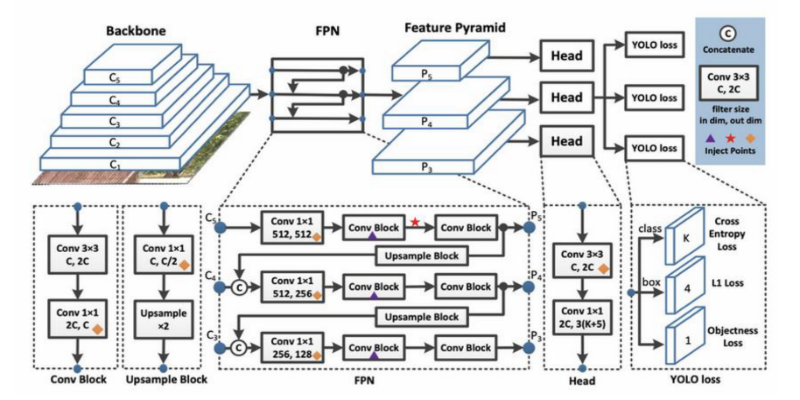

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
from google.colab.patches import cv2_imshow
%cd '/content/drive/MyDrive/YOLO'
img_path = './neck.jpg'

img =cv2.imread(img_path)
img_resized = cv2.resize(img, (800, 400))
cv2_imshow(img_resized)
# FPN(Feature Pyramid Networks for Object Detection)-> 컴퓨팅 자원을 적게 차지하면서 다양한 크기의 객체를 인식하는 방법을 제시

In [ ]:
# 이부분은 모델을 만드는 부분
# 총 3개의 layer를 return 함 (소,중,대 물체탐지용 layer)

def YOLOv3(input_layer, NUM_CLASS):
  # Darknet-53 함수에서 3개의 Layer 뭉치가 나옴
  route_1, route_2, conv = darknet53(input_layer)
  # 사진에 보이는 C5가 위의 conv에 해당
  # FPN을 수행하기 위해 Conv Block 추가하기
  conv = convolutional(conv, (1, 1, 1024,  512))
  conv = convolutional(conv, (3, 3,  512, 1024)) # Conv Block C=512
  conv = convolutional(conv, (1, 1, 1024,  512))
  conv = convolutional(conv, (3, 3,  512, 1024))
  conv = convolutional(conv, (1, 1, 1024,  512))
  conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024)) # Head 부문 만들기 C=512 
  #큰 크기 물체에 대해 검출하기 위해 만든 P5 K는 NUM_CLASS에 해당
  conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)
  # input image 416x416이 들어가면 결과로 feature map 13x13x255가 나옴

  conv = convolutional(conv, (1, 1,  512,  256)) # 위에 보면 Upsample Block에서 추가함
  conv = upsample(conv) #P5가기 전에 Layer를 가져와서 Upsample 해줌

  conv = tf.concat([conv, route_2], axis=-1) # concatenate -> conv와 route_2 Layer 합쳐주기
  conv = convolutional(conv, (1, 1, 768, 256)) 
  conv = convolutional(conv, (3, 3, 256, 512)) # Conv Block C=256
  conv = convolutional(conv, (1, 1, 512, 256))
  conv = convolutional(conv, (3, 3, 256, 512))
  conv = convolutional(conv, (1, 1, 512, 256))
  conv_mobj_branch = convolutional(conv, (3, 3, 256, 512)) # Head 부문 만들기 C=256
  #중간 크기 물체에 대해 검출하기 위해 만든 P4 K는 NUM_CLASS에 해당
  conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)
  # input image 416x416이 들어가면 결과로 feature map 26x26x255가 나옴

  conv = convolutional(conv, (1, 1, 256, 128))# 위에 보면 Upsample Block에서 추가함
  conv = upsample(conv) #P4가기 전에 Layer를 가져와서 Upsample 해줌

  conv = tf.concat([conv, route_1], axis=-1) # 앞의 conv와 route_1 Layer 합쳐주기
  conv = convolutional(conv, (1, 1, 384, 128))
  conv = convolutional(conv, (3, 3, 128, 256)) # Conv Block C=128
  conv = convolutional(conv, (1, 1, 256, 128))
  conv = convolutional(conv, (3, 3, 128, 256))
  conv = convolutional(conv, (1, 1, 256, 128))
  conv_sobj_branch = convolutional(conv, (3, 3, 128, 256)) # Head 부문 만들기 C=128
    
  # 작은 크기 물체에 대해 검출하기 위해 만든 P3 K는 NUM_CLASS에 해당
  conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
  # input image 416x416이 들어가면 결과로 feature map 52x52x255가 나옴

  return [conv_sbbox, conv_mbbox, conv_lbbox] # 각각의 Kernel size는 1x1x255
  # 255는 (좌표 값 4개 + confidence 1개 + Class 80개) * (Bounding box 각각 3개) = 85 * 3
# 작은, 중간, 큰 사이즈 객체 검출에 해당하는 각 Head들 return

### **3) Darknet() Code**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/YOLO


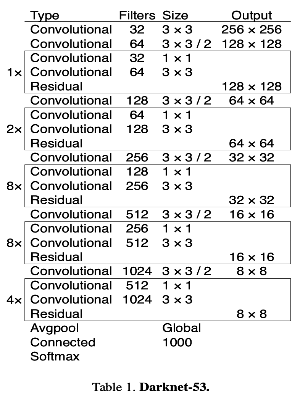

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
from google.colab.patches import cv2_imshow
%cd '/content/drive/MyDrive/YOLO'
img_path = './dark.jpg'

img =cv2.imread(img_path)
img_resized = cv2.resize(img, (300, 400))
cv2_imshow(img_resized)

In [ ]:
# convolutional 함수:
# input_layer, filter_shape, downsampling 여부를 입력 받아 conv2D layer 생성
# filter_shape = filter size (2개), 전 filter channel 개수(1개), 바꿔줄 filter channel 개수(1개)

# residual_block 함수:
# Darknet53에 존재하는 [Conv,Conv,Residual]조합의 Layer 생성

# 이부분은 모델을 만드는 부분
def darknet53(input_data):
  input_data=convolutional(input_data, (3, 3, 3, 32)) # 첫번째 conv layer 생성
  input_data=convolutional(input_data, (3, 3, 32, 64), downsample=True) # ZeroPadding으로 downsample 256->128

  for i in range(1):
    input_data = residual_block(input_data,  64,  32, 64) # 첫번째 1x [conv,conv,residual] Layer

  input_data=convolutional(input_data,(3, 3, 64, 128), downsample=True) # ZeroPadding으로 downsample 128->64

  for i in range(2):
    input_data = residual_block(input_data, 128,  64, 128)  # 첫번째 2x [conv,conv,residual] Layer

  input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True) # ZeroPadding으로 downsample 64->32

  for i in range(8):
    input_data = residual_block(input_data, 256, 128, 256) # 첫번째 8x [conv,conv,residual] Layer

  route_1 = input_data # FPN(Feature pyramid networks for object detection) 위한 Layer 중간 저장

  input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True) # ZeroPadding으로 downsample 32->16

  for i in range(8):
    input_data = residual_block(input_data, 512, 256, 512) # 첫번째 8x [conv,conv,residual] Layer

  route_2 = input_data # FPN(Feature pyramid networks for object detection) 위한 Layer 중간 저장

  input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True) # ZeroPadding으로 downsample 16->8

  for i in range(4):
    input_data = residual_block(input_data, 1024, 512, 1024) # 첫번째 4x [conv,conv,residual] Layer

  return route_1, route_2, input_data 
# 총 3개의 Layer 뭉치들이 나옴 -> 다양한 크기의 feature map을 사용하여 detetion 수행
# Backbone의 최종, 중간, 초기 Feature map을 FPN에 사용

### **4) Decode() Code**

In [ ]:
# 이부분은 input 이미지 416x416x3이 모델에 들어가 Output으로 나온 값들
# 즉, 특징들이 들어있는 3개의 Feature map들에 Sigmoid 함수를 적용해 값들을 예측함

def decode(conv_output, NUM_CLASS, i=0):
  conv_shape = tf.shape(conv_output) # conv_output의 형태 알아보기
  batch_size = conv_shape[0]
  output_size = conv_shape[1]
  # 논문에서 설명한 NxNx[3*(4+1+80)] 구조의 Tensor N=13,26,52 중 하나
  conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

  #conv_raw_dxdy = conv_output[:,:,:,:,0:2] # 중심좌표 x,y 부분
  #conv_raw_dwdh = conv_output[:,:,:,:,2:4] # 예측한 box의 w,h 부분
  #conv_raw_conf = conv_output[:,:,:,:,4:5] # 예측한 박스의 Confidence 깂
  #conv_raw_prob = conv_output[:,:,:,:,5:] # 각 Class들에 해당한 확률값
  conv_raw_dxdy,conv_raw_dwdh,conv_raw_conf,conv_raw_prob = tf.split(conv_output,
                                                                     (2,2,1,NUM_CLASS),axis=-1)
  # 앞의 feature map output size가 13,26,52로 나옴
  # output_size 기준으로 meshgrid 만들기
  xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
  # meshgrid를 좌표만들어 주기
  xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
  # x,y 기준으로 3개씩 만들어 주기
  xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [batch_size, 1, 1, 3, 1])
  xy_grid = tf.cast(xy_grid, tf.float32)
  # shape = (batch_size, output_size, output_size, 3, 2)

  # STRIDES=[8, 16, 32] -> 416 / (3개의 feature map 크기)
  # 작은 박스 먼저 decode를 수행함, 52x52x255 feature map이 들어옴
  # 따라서 52*8=416 임으로 416으로 만들기 위해 STRIDES를 곱해줌
  # 안에 있는 식은 논문에서 나온 x,y좌표를 sigmoid를 하고 + grid 사이즈를 더함
  pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]
  # 여기도 동일하게 지수함수와 작은,중간,큰 각각 3개의 ANCHOR BOX의 사이즈를 곱함
  pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

  pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1) # x,y,w,h 다 합쳐줌
  pred_conf = tf.sigmoid(conv_raw_conf) # confidence 값에 sigmoid 적용
  pred_prob = tf.sigmoid(conv_raw_prob) # 각 CLASS에 해당하는 확률도 sigmoid 적용

  # 정리를 마친 값들 하나로 합쳐서 Return
  return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

### **5) Detect_image() -> nms() Code**

In [ ]:
# 들어가기 앞서 nms 함수는 bboxes와 미리 설정된 Iou_threshold 값을 입력받음
# 각각 Class 중 순차적으로 가장 좋은 결과를 갖는 bbox는 최종 리스트에 추가함
# 리스트에 추가한 박스와 중복적으로 detect된 bbox를 삭제하기 위해
# 해당 class에 존재하는 bbox들과 최종 리스트에 추가된 bbox 사이의 iou를 구함
# 나온 iou 값이 Iou_threshold 보다 높으면 같은 물체를 detect한 bbox로 보고
# weight값을 곱해 해당 bbox를 삭제 함.
# bboxes의 형식은 (xmin, ymin, xmax, ymax, score, class) 임

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
  # class list를 classes_in_img 변수에 넣어주기
  classes_in_img = list(set(bboxes[:,5]))
  # return 할 list 생성
  best_bboxes = []

  for clas in classes_in_img: # 각각 class들에 대해서 for문
    cls_mask = (bboxes[:, 5] == cls) # 해당 class의 index 값들 cls_mask에 저장
    cls_bboxes = bboxes[cls_mask] # 해당 class의 bboxes 모음
    # 해당 class에 예측한 Bounding box가 존재하는 동안은 while 돌림
    while len(cls_bboxes) > 0:
      # 해당 class에서 가장 좋은 score를 갖는 bbox 찾기
      max_ind = np.argmax(cls_bboxes[:, 4]) # 가장 좋은 결과를 주는 index 값
      best_bbox = cls_bboxes[max_ind] # 가장 좋은 결과를 주는 박스 bbox 값
      best_bboxes.append(best_bbox) # best_bboxes에 추가
      # max_ind의 bbox 값을 cls_bboxes에서 빼주기
      cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
      # socre가 가장 높았던 bbox와 남은 bbox의 iou 구하기
      iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
      # 중복되는 bbox 값들 지워주기 위해 weight array 하나 만듦
      weight = np.ones((len(iou),), dtype=np.float32)

      assert method in ['nms', 'soft-nms']

      if method == 'nms': # 이걸 사용함
        # iou_threshold 값보다 iou가 커버리면 해당 index weight에 0대입
        iou_mask = iou > iou_threshold
        weight[iou_mask] = 0.0

      if method == 'soft-nms':
        weight = np.exp(-(1.0 * iou ** 2 / sigma))

      # 같은 물체에 대해 중복되는 bbox 삭제 시켜주기
      cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
      score_mask = cls_bboxes[:, 4] > 0.
      cls_bboxes = cls_bboxes[score_mask]

  return best_bboxes

### **Final) Detecting Image with YOLO_v3**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#%cd /content/drive/MyDrive/YOLO

#!unzip -qq "/content/drive/MyDrive/YOLO/TensorFlow-2.x-YOLOv3-master.zip"

%cd '/content/drive/MyDrive/YOLO/TensorFlow-2.x-YOLOv3-master'
!pip install -r ./requirements.txt

!wget -P model_data https://pjreddie.com/media/files/yolov3.weights

/content/drive/MyDrive/YOLO/TensorFlow-2.x-YOLOv3-master


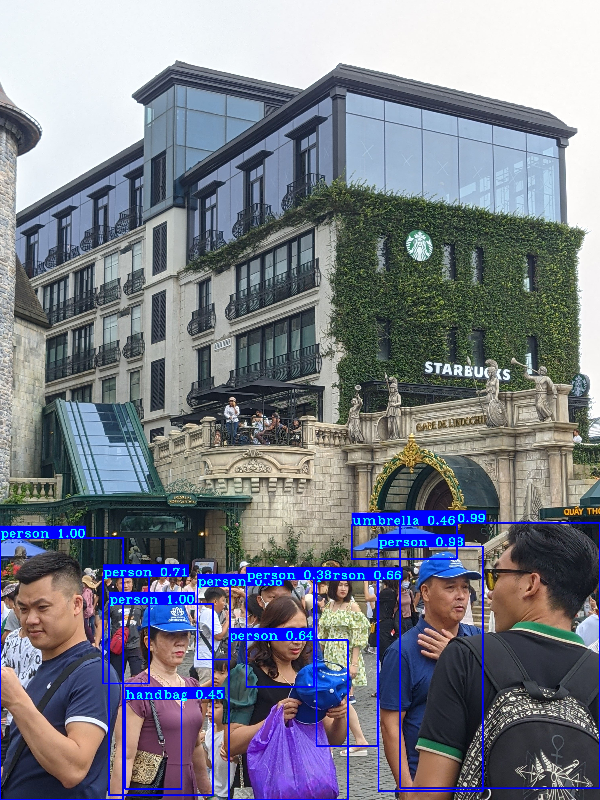

In [ ]:
#!python detection_demo.py
import cv2
from google.colab.patches import cv2_imshow
%cd '/content/drive/MyDrive/YOLO/TensorFlow-2.x-YOLOv3-master'
img_path = './IMAGES/3_pred.jpg'

img =cv2.imread(img_path)
img_resized = cv2.resize(img, (600, 800))
cv2_imshow(img_resized)